In [1]:
import sys
sys.path.append("..")
sys.path.append("../src/")
sys.path.append("../src/algs/")

from src import interface
from src import simulator
from src import algs

import numpy as np
import matplotlib.pyplot as plt

# Experiment 1: Greedy Vs Deferred Vs Lookahead
-- batch saved for later

In [2]:
def weight_function_distance(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(1 + (bx-sx)**2 + (by-sy)**2)

In [3]:
departure_distr = (6,1) # mean, var
seed = 42
p_node = 1 # add a node every step
num_runs = 1000

In [4]:
algs_to_test = [
    ("greedy", algs.Greedy()),
    ("dfa", algs.DynamicDeferredAcceptance()),
    ("lookahead1", algs.DeferredWithLookAhead(1)),
    ("lookahead3", algs.DeferredWithLookAhead(3)),
    ("lookahead5", algs.DeferredWithLookAhead(5))
]

## actually run one of the experiments

In [5]:
results = {}
for (alg_name, alg) in algs_to_test:
    inter = interface.Interface(
        alg,
        simulator.Simulator(weight_function_distance),
        p_node=p_node,
        seed=seed,
        dep_distr=departure_distr,
        verbose=False)
    results[alg_name] = inter.run(num_runs)

In [6]:
for alg_name, res in results.items():
    average_weight =  np.mean([w[0] for w in res[0]])
    print("The {} algorithm had an average weight of {}".format(alg_name, average_weight))


The greedy algorithm had an average weight of 0.24491590695078122
The dfa algorithm had an average weight of 0.20909926414303612
The lookahead1 algorithm had an average weight of 0.20909926414303612
The lookahead3 algorithm had an average weight of 0.20909926414303612
The lookahead5 algorithm had an average weight of 0.20909926414303612


# Let's run a few experiments...

In [7]:
def run_an_experiment(seed, p_node, departure_distr, algs_to_test, weight_fn,
                      fewest_nodes_per_add=1, max_nodes_per_add=10,
                      p_buyer=0.5, num_runs=1000, size=(10,10), recalc=False):
    results = {}
    for (alg_name, alg) in algs_to_test:
        inter = interface.Interface(
            alg,
            simulator.Simulator(weight_fn),
            p_node=p_node,
            min_to_add=fewest_nodes_per_add,
            max_to_add=max_nodes_per_add,
            p_buyer=p_buyer,
            seed=seed,
            dep_distr=departure_distr,
            recalc_weights=recalc)
        results[alg_name] = inter.run(num_runs)
    for alg_name, res in results.items():
        average_weight =  np.mean([w[0] for w in res[0]])
        print("The {} algorithm had an average weight of {}".format(alg_name, average_weight))
    return results


In [8]:
def weight_function_distance(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(1 + (bx-sx)**2 + (by-sy)**2)

In [9]:
algs_to_test = [
    ("greedy", algs.Greedy()),
    ("dfa", algs.DynamicDeferredAcceptance()),
    ("lookahead1", algs.DeferredWithLookAhead(1)),
    ("lookahead3", algs.DeferredWithLookAhead(3)),
    ("lookahead5", algs.DeferredWithLookAhead(5))
]
results1 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results1[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.5, num_runs=500, size=(10,10))


Seed: 0
The greedy algorithm had an average weight of 0.41633861974262093
The dfa algorithm had an average weight of 0.36551927356512703
The lookahead1 algorithm had an average weight of 0.35046899716758073
The lookahead3 algorithm had an average weight of 0.37637846161267574
The lookahead5 algorithm had an average weight of 0.3353204734573441


In [10]:
def weight_function_d_and_time(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return (buyer_d + seller_d)/(1 + (bx-sx)**2 + (by-sy)**2)

## This is not the right function I was thinking of. Need a node->time_waiting variable somehow.
Requires redefining the way sim works, which I just don't have the energy for at the moment. I added the functionality to interface, where it returns the original weight times of matches. So we can do something with that after the fact (it wont be considered by algorithms). We may also want to check something like average market density - how many buyers/sellers present on average?

In [11]:
results2 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results2[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, 
                                      weight_function_d_and_time,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)


Seed: 0
The greedy algorithm had an average weight of 2.5222050873719004
The dfa algorithm had an average weight of 1.723709234737759
The lookahead1 algorithm had an average weight of 1.918841801898989
The lookahead3 algorithm had an average weight of 1.6222252928645655
The lookahead5 algorithm had an average weight of 1.7498474019067884


In [12]:
results3 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results3[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, 
                                       weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.6, num_runs=500, size=(10,10))


Seed: 0
The greedy algorithm had an average weight of 0.4211391257310827
The dfa algorithm had an average weight of 0.35315997894449114
The lookahead1 algorithm had an average weight of 0.32184209295382177
The lookahead3 algorithm had an average weight of 0.34522186846899405
The lookahead5 algorithm had an average weight of 0.325247291659145


In [13]:
results4 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results4[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, 
                                       weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.4, num_runs=500, size=(10,10))


Seed: 0
The greedy algorithm had an average weight of 0.42598108091369546
The dfa algorithm had an average weight of 0.3682993098886394
The lookahead1 algorithm had an average weight of 0.37650595928142994
The lookahead3 algorithm had an average weight of 0.36663330007653233
The lookahead5 algorithm had an average weight of 0.3650310323831039


In [14]:
def print_some_things(result_dict):
    for seed in result_dict.keys():
        print("Seed:", seed)
        for alg_name, res in result_dict[seed].items():
            print("Alg:", alg_name)
            weights, discarded_buyers, discarded_sellers, matched_wait_times = res
            avg_weight_matching = np.mean([w[0] for w in weights])
            n_matched_nodes = len(weights)*2 # because a match is 2 nodes
            num_discarded_buyers = np.sum([d[0] for d in discarded_buyers])
            num_discarded_sellers = np.sum([d[0] for d in discarded_sellers])
            n_nodes = n_matched_nodes + num_discarded_buyers + num_discarded_sellers
            avg_weight_per_node = (avg_weight_matching * n_matched_nodes) / n_nodes
            print("Average weight per matching:", avg_weight_matching)
            print("Average weight per node:", avg_weight_per_node)
            print("Number of nodes: {}, matches: {}".format(n_nodes, len(weights)))
            print("Number of dropped buyers: {}, sellers: {}".format(
                num_discarded_buyers,
                num_discarded_sellers
            ))

In [15]:
print_some_things(results1)

Seed: 0
Alg: greedy
Average weight per matching: 0.41633861974262093
Average weight per node: 0.2215225066557632
Number of nodes: 1481, matches: 394
Number of dropped buyers: 355, sellers: 338
Alg: dfa
Average weight per matching: 0.36551927356512703
Average weight per node: 0.23315015392014277
Number of nodes: 1458, matches: 465
Number of dropped buyers: 235, sellers: 293
Alg: lookahead1
Average weight per matching: 0.35046899716758073
Average weight per node: 0.23271513756147458
Number of nodes: 1506, matches: 500
Number of dropped buyers: 246, sellers: 260
Alg: lookahead3
Average weight per matching: 0.37637846161267574
Average weight per node: 0.25008201985738826
Number of nodes: 1499, matches: 498
Number of dropped buyers: 264, sellers: 239
Alg: lookahead5
Average weight per matching: 0.3353204734573441
Average weight per node: 0.22142948720863861
Number of nodes: 1478, matches: 488
Number of dropped buyers: 256, sellers: 246


In [16]:
print_some_things(results2)

Seed: 0
Alg: greedy
Average weight per matching: 2.5222050873719004
Average weight per node: 0.8750174283697985
Number of nodes: 1545, matches: 268
Number of dropped buyers: 499, sellers: 510
Alg: dfa
Average weight per matching: 1.723709234737759
Average weight per node: 0.9922288767566751
Number of nodes: 1494, matches: 430
Number of dropped buyers: 326, sellers: 308
Alg: lookahead1
Average weight per matching: 1.918841801898989
Average weight per node: 1.018786266078106
Number of nodes: 1503, matches: 399
Number of dropped buyers: 338, sellers: 367
Alg: lookahead3
Average weight per matching: 1.6222252928645655
Average weight per node: 0.9330011588742925
Number of nodes: 1464, matches: 421
Number of dropped buyers: 327, sellers: 295
Alg: lookahead5
Average weight per matching: 1.7498474019067884
Average weight per node: 0.9576867537462828
Number of nodes: 1480, matches: 405
Number of dropped buyers: 333, sellers: 337


In [17]:
print_some_things(results3)

Seed: 0
Alg: greedy
Average weight per matching: 0.4211391257310827
Average weight per node: 0.2149417373121802
Number of nodes: 1493, matches: 381
Number of dropped buyers: 541, sellers: 190
Alg: dfa
Average weight per matching: 0.35315997894449114
Average weight per node: 0.23669232631386108
Number of nodes: 1504, matches: 504
Number of dropped buyers: 393, sellers: 103
Alg: lookahead1
Average weight per matching: 0.32184209295382177
Average weight per node: 0.22281375666033815
Number of nodes: 1508, matches: 522
Number of dropped buyers: 402, sellers: 62
Alg: lookahead3
Average weight per matching: 0.34522186846899405
Average weight per node: 0.2362991928894679
Number of nodes: 1534, matches: 525
Number of dropped buyers: 375, sellers: 109
Alg: lookahead5
Average weight per matching: 0.325247291659145
Average weight per node: 0.22565522570080776
Number of nodes: 1499, matches: 520
Number of dropped buyers: 386, sellers: 73


In [18]:
print_some_things(results4)

Seed: 0
Alg: greedy
Average weight per matching: 0.42598108091369546
Average weight per node: 0.21170660551772408
Number of nodes: 1493, matches: 371
Number of dropped buyers: 261, sellers: 490
Alg: dfa
Average weight per matching: 0.3682993098886394
Average weight per node: 0.20469475676220067
Number of nodes: 1461, matches: 406
Number of dropped buyers: 170, sellers: 479
Alg: lookahead1
Average weight per matching: 0.37650595928142994
Average weight per node: 0.22777221681545928
Number of nodes: 1491, matches: 451
Number of dropped buyers: 170, sellers: 419
Alg: lookahead3
Average weight per matching: 0.36663330007653233
Average weight per node: 0.20425973699609348
Number of nodes: 1418, matches: 395
Number of dropped buyers: 154, sellers: 474
Alg: lookahead5
Average weight per matching: 0.3650310323831039
Average weight per node: 0.20962178097247552
Number of nodes: 1515, matches: 435
Number of dropped buyers: 167, sellers: 478


In [19]:
import pandas as pd

In [84]:
def make_dataframe(results, seed=0):
    aggregates = {}
    for alg_name, res in results[seed].items():
        weights, discarded_buyers, discarded_sellers, matched_wait_times = res
        just_weights = [w[0] for w in weights]
        avg_weight_matching = np.mean(just_weights)
        n_matched_nodes = len(weights)*2 # because a match is 2 nodes
        num_discarded_buyers = np.sum([d[0] for d in discarded_buyers])
        num_discarded_sellers = np.sum([d[0] for d in discarded_sellers])
        n_nodes = n_matched_nodes + num_discarded_buyers + num_discarded_sellers
        avg_weight_per_node = (avg_weight_matching * n_matched_nodes) / n_nodes
        this_alg_aggregates = {}
        this_alg_aggregates["avg_weight_matching"] = avg_weight_matching
        this_alg_aggregates["avg_weight_per_node"] = avg_weight_per_node
        weights_with_0s = []
        for match in just_weights:
            weights_with_0s.extend([match,match])
        weights_with_0s.extend([0]*(num_discarded_buyers + num_discarded_sellers))
        this_alg_aggregates["weight_per_node_stddev"] = np.std(weights_with_0s)
        this_alg_aggregates["num_discarded_sellers"] = num_discarded_sellers
        this_alg_aggregates["num_discarded_buyers"] = num_discarded_buyers
        aggregates[alg_name] = this_alg_aggregates
    return pd.DataFrame(aggregates)



In [85]:
make_dataframe(results1)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,0.365519,0.416339,0.350469,0.376378,0.335320
avg_weight_per_node,0.233150,0.221523,0.232715,0.250082,0.221429
num_discarded_buyers,235.000000,355.000000,246.000000,264.000000,256.000000
num_discarded_sellers,293.000000,338.000000,260.000000,239.000000,246.000000
weight_per_node_stddev,0.289529,0.281174,0.288016,0.287652,0.276421


In [86]:
make_dataframe(results2)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,1.723709,2.522205,1.918842,1.622225,1.749847
avg_weight_per_node,0.992229,0.875017,1.018786,0.933001,0.957687
num_discarded_buyers,326.000000,499.000000,338.000000,327.000000,333.000000
num_discarded_sellers,308.000000,510.000000,367.000000,295.000000,337.000000
weight_per_node_stddev,1.487960,1.568882,1.598831,1.392321,1.467428


In [87]:
make_dataframe(results3)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,0.353160,0.421139,0.321842,0.345222,0.325247
avg_weight_per_node,0.236692,0.214942,0.222814,0.236299,0.225655
num_discarded_buyers,393.000000,541.000000,402.000000,375.000000,386.000000
num_discarded_sellers,103.000000,190.000000,62.000000,109.000000,73.000000
weight_per_node_stddev,0.286587,0.286497,0.260082,0.287262,0.274015


In [88]:
make_dataframe(results4)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,0.368299,0.425981,0.376506,0.366633,0.365031
avg_weight_per_node,0.204695,0.211707,0.227772,0.204260,0.209622
num_discarded_buyers,170.000000,261.000000,170.000000,154.000000,167.000000
num_discarded_sellers,479.000000,490.000000,419.000000,474.000000,478.000000
weight_per_node_stddev,0.283773,0.280262,0.289507,0.271003,0.272604


In [90]:
# difference is weighting of time / distance components.
def weight_function_d_and_time_sep1(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return (buyer_d + seller_d) + 1/(1 + (bx-sx)**2 + (by-sy)**2)
def weight_function_d_and_time_sep2(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return (buyer_d + seller_d) + 10*1/(1 + (bx-sx)**2 + (by-sy)**2)
def weight_function_d_and_time_sep3(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 10*(buyer_d + seller_d) + 1/(1 + (bx-sx)**2 + (by-sy)**2)

results_time_sep_1 = {}
results_time_sep_2 = {}
results_time_sep_3 = {}
seed = 0
results_time_sep_1[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep1,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
results_time_sep_2[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep2,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
results_time_sep_3[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep3,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
    

/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The greedy algorithm had an average weight of nan
The dfa algorithm had an average weight of 5.3370823850885065
The lookahead1 algorithm had an average weight of 5.4370436672771865
The lookahead3 algorithm had an average weight of 5.741496413616814
The lookahead5 algorithm had an average weight of 5.5511486957429454
The greedy algorithm had an average weight of 13.636363636363637
The dfa algorithm had an average weight of 8.929159154747966
The lookahead1 algorithm had an average weight of 8.94846736690906
The lookahead3 algorithm had an average weight of 8.96976739978507
The lookahead5 algorithm had an average weight of 9.264271007632214
The greedy algorithm had an average weight of nan
The dfa algorithm had an average weight of 51.84335504140279
The lookahead1 algorithm had an average weight of 54.96597085283391
The lookahead3 algorithm had an average weight of 56.25879655153048
The lookahead5 algorithm had an average weight of 54.16657311659208


In [91]:
make_dataframe(results_time_sep_1)

/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,5.337082,NaN,5.437044,5.741496,5.551149
avg_weight_per_node,1.940076,NaN,2.113414,1.850825,2.132476
num_discarded_buyers,457.000000,745.0,469.000000,464.000000,442.000000
num_discarded_sellers,450.000000,761.0,462.000000,524.000000,475.000000
weight_per_node_stddev,2.783290,0.0,2.899265,2.871310,2.938212


In [92]:
make_dataframe(results_time_sep_2)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,8.929159,13.636364,8.948467,8.969767,9.264271
avg_weight_per_node,4.194091,1.204013,4.191746,4.137952,4.241172
num_discarded_buyers,390.000000,638.000000,403.000000,410.000000,398.000000
num_discarded_sellers,389.000000,725.000000,380.000000,356.000000,405.000000
weight_per_node_stddev,5.007646,3.956010,4.973823,4.998293,5.138095


In [93]:
make_dataframe(results_time_sep_3)

/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,51.843355,NaN,54.965971,56.258797,54.166573
avg_weight_per_node,18.139881,NaN,19.121859,21.219393,20.019625
num_discarded_buyers,474.000000,692.0,476.000000,466.000000,492.000000
num_discarded_sellers,481.000000,805.0,480.000000,429.000000,470.000000
weight_per_node_stddev,27.011745,0.0,28.115934,29.319995,28.208929


Seems like have the weight function depend heavily on time makes the greedy algorithm break?

In [94]:
results_big_one = {}
for seed in [0]:
    print("\nSeed:", seed)
    results_big_one[seed] = run_an_experiment(
        seed, 0.9, (10,2), algs_to_test, 
        weight_function_distance,
        fewest_nodes_per_add=1, max_nodes_per_add=10,
        p_buyer=0.5, num_runs=1000, size=(20,20))


Seed: 0
The greedy algorithm had an average weight of 0.6222476617659023
The dfa algorithm had an average weight of 0.5249575687551369
The lookahead1 algorithm had an average weight of 0.5291354847738865
The lookahead3 algorithm had an average weight of 0.539378944837527
The lookahead5 algorithm had an average weight of 0.5258664578469614


In [95]:
make_dataframe(results_big_one)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,0.524958,0.622248,0.529135,0.539379,0.525866
avg_weight_per_node,0.344388,0.328744,0.361886,0.357612,0.360045
num_discarded_buyers,813.000000,1228.000000,851.000000,777.000000,775.000000
num_discarded_sellers,847.000000,1179.000000,749.000000,942.000000,778.000000
weight_per_node_stddev,0.348528,0.369882,0.357087,0.356990,0.353956


In [89]:
import numpy as np
import matplotlib.pyplot as plt


In [65]:
def get_weights_for_histogram(results, seed=0):
    all_weights = {}
    max_weight = -1000
    n_bins=100
    lowest = 0
    for alg_name, res in results[seed].items():
        weights, discarded_buyers, discarded_sellers, matched_wait_times = res
        just_weights = [w[0] for w in weights]
        max_weight = max(max_weight, max(just_weights))
        all_weights[alg_name] = just_weights
    hist_values = {}
    for alg in all_weights.keys():
        hist_values[alg], bins = np.histogram(np.array(all_weights[alg]), n_bins, (lowest, max_weight))
    return pd.DataFrame(hist_values), bins




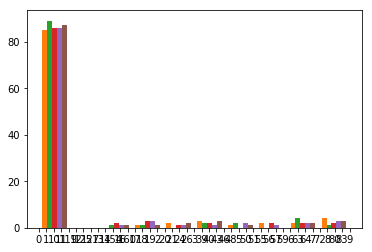

In [72]:
df, bins = get_weights_for_histogram(results1)
plt.hist(df)
plt.show()